In [3]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geoip2.database
import myLogReader as mlr
import re
import os
import sys
import datetime as dt
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_absolute_error

%matplotlib inline

## Automate - Read and Prep log data into DF

In [2]:
logsPath = '../data/logs'
geoLiteIPDBPath = '../data/GeoLite2-City_20181009/GeoLite2-City.mmdb'

#Create a myLogReader object
myLogReader = mlr.log()
#Open Reader
myLogReader.openReader(geoLiteIPDBPath)

In [ ]:
x = myLogReader.readLog('../data/logs/u_ex171218.log')

In [ ]:
x.head()

In [ ]:
for i in range(1,304):
    print ('AggregatedData_week_%d.csv' % i)
    df =  myLogReader.readLogs(logsPath,1)
    df.to_csv('../data/AggregatedData_DAY_%d.csv' % i)

In [ ]:
#Close Reader
myLogReader.closeReader()

In [ ]:
df.head()

## 2- Load PlacementSummary and Logs Data aggregated per week

In [3]:
log_aggregated_per_week_df = pd.read_csv('../data/LogsAggregatedData_per_week.csv')
log_aggregated_per_week_df.set_index('calendar-year-week',inplace=True)

In [4]:
log_aggregated_per_week_df.head()

,client-ip-unique-count,cs-username-unique-count,client-connections-count,time-taken(ms)-sum,Chrome-count,Firefox-count,Other-count,Safari-count,Desktop-count,Mobile-count
calendar-year-week,,,,,,,,,,
2017-50,925,415,89497,52520170.0,38500,7784,27741,15472,80440,9057
2017-51,866,386,81378,44703569.0,39664,6585,21274,13855,72925,8453
2017-52,475,179,30843,14199684.0,9978,553,14279,6033,27735,3108
2018-01,769,354,71528,42663674.0,31666,8049,19512,12301,64710,6818
2018-02,920,441,90093,63904084.0,38238,6166,23249,22440,79099,10994


In [5]:
placement_summary_df = pd.read_csv('../data/PlacementSummary.csv')
placement_summary_df.set_index('YearWeek',inplace=True)

In [6]:
placement_summary_df.head()

,PlacementCount,PlacementCompletedCount,PlacementAllocatedInProgressCount,PlacementAllocatedCount,PlacementNotAllocatedCount
YearWeek,,,,,
2017-50,246,48,234,238,8
2017-51,198,77,196,197,1
2017-52,116,3,115,116,0
2017-53,113,17,96,113,0
2018-01,113,4,111,113,0


In [7]:
log_and_placements_aggregated_per_week_df = log_aggregated_per_week_df.join(placement_summary_df)
log_and_placements_aggregated_per_week_df.head()

,client-ip-unique-count,cs-username-unique-count,client-connections-count,time-taken(ms)-sum,Chrome-count,Firefox-count,Other-count,Safari-count,Desktop-count,Mobile-count,PlacementCount,PlacementCompletedCount,PlacementAllocatedInProgressCount,PlacementAllocatedCount,PlacementNotAllocatedCount
calendar-year-week,,,,,,,,,,,,,,,
2017-50,925,415,89497,52520170.0,38500,7784,27741,15472,80440,9057,246,48,234,238,8
2017-51,866,386,81378,44703569.0,39664,6585,21274,13855,72925,8453,198,77,196,197,1
2017-52,475,179,30843,14199684.0,9978,553,14279,6033,27735,3108,116,3,115,116,0
2018-01,769,354,71528,42663674.0,31666,8049,19512,12301,64710,6818,113,4,111,113,0
2018-02,920,441,90093,63904084.0,38238,6166,23249,22440,79099,10994,159,7,159,159,0


In [8]:
log_and_placements_aggregated_per_week_df.isna().sum()

client-ip-unique-count               0
cs-username-unique-count             0
client-connections-count             0
time-taken(ms)-sum                   0
Chrome-count                         0
Firefox-count                        0
Other-count                          0
Safari-count                         0
Desktop-count                        0
Mobile-count                         0
PlacementCount                       0
PlacementCompletedCount              0
PlacementAllocatedInProgressCount    0
PlacementAllocatedCount              0
PlacementNotAllocatedCount           0
dtype: int64

In [9]:
log_and_placements_aggregated_per_week_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43 entries, 2017-50 to 2018-40
Data columns (total 15 columns):
client-ip-unique-count               43 non-null int64
cs-username-unique-count             43 non-null int64
client-connections-count             43 non-null int64
time-taken(ms)-sum                   43 non-null float64
Chrome-count                         43 non-null int64
Firefox-count                        43 non-null int64
Other-count                          43 non-null int64
Safari-count                         43 non-null int64
Desktop-count                        43 non-null int64
Mobile-count                         43 non-null int64
PlacementCount                       43 non-null int64
PlacementCompletedCount              43 non-null int64
PlacementAllocatedInProgressCount    43 non-null int64
PlacementAllocatedCount              43 non-null int64
PlacementNotAllocatedCount           43 non-null int64
dtypes: float64(1), int64(14)
memory usage: 6.6+ KB


In [9]:
fig_size= plt.rcParams["figure.figsize"]

# Set figure width to 12 and height to 9
fig_size[0] = 20
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size


print ("Current size:",fig_size)

Current size: [20, 7]


Current size: [20, 7]


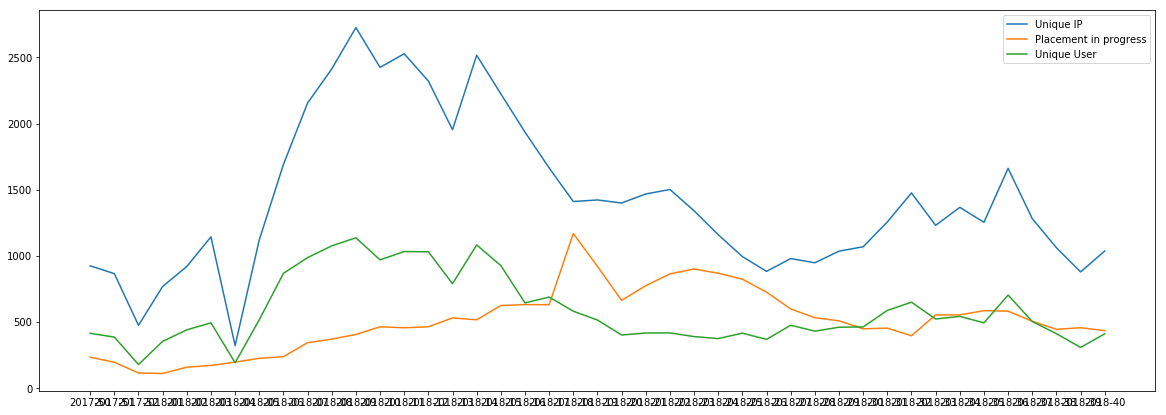

In [10]:
plt.plot(log_and_placements_aggregated_per_week_df.index,log_and_placements_aggregated_per_week_df['client-ip-unique-count'],label="Unique IP")
plt.plot(log_and_placements_aggregated_per_week_df.index,log_and_placements_aggregated_per_week_df['PlacementAllocatedInProgressCount'],label="Placement in progress")
plt.plot(log_and_placements_aggregated_per_week_df.index,log_and_placements_aggregated_per_week_df['cs-username-unique-count'],label="Unique User")
plt.legend()

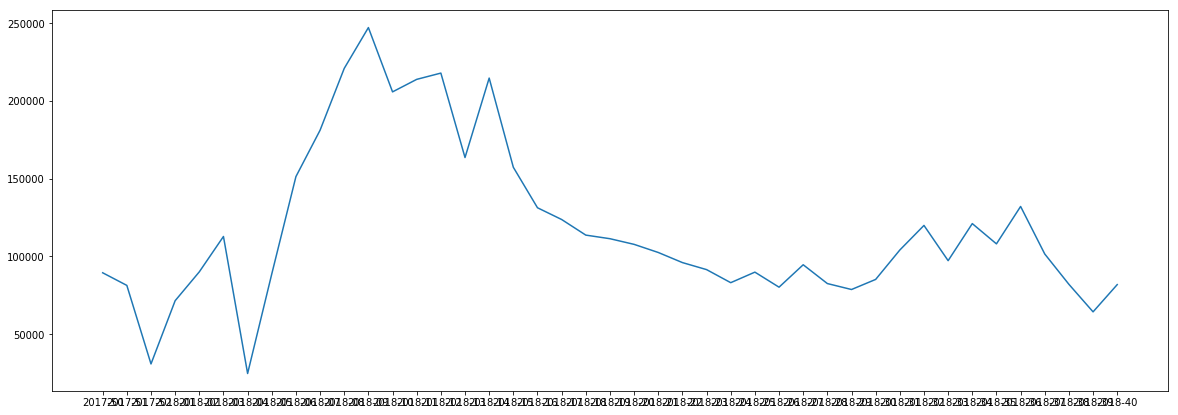

In [11]:

plt.plot(log_and_placements_aggregated_per_week_df.index,log_and_placements_aggregated_per_week_df['client-connections-count'],label="Http Requests Count")

In [12]:
log_and_placements_aggregated_per_week_df.columns

Index(['client-ip-unique-count', 'cs-username-unique-count',
       'client-connections-count', 'time-taken(ms)-sum', 'Chrome-count',
       'Firefox-count', 'Other-count', 'Safari-count', 'Desktop-count',
       'Mobile-count', 'PlacementCount', 'PlacementCompletedCount',
       'PlacementAllocatedInProgressCount', 'PlacementAllocatedCount',
       'PlacementNotAllocatedCount'],
      dtype='object')

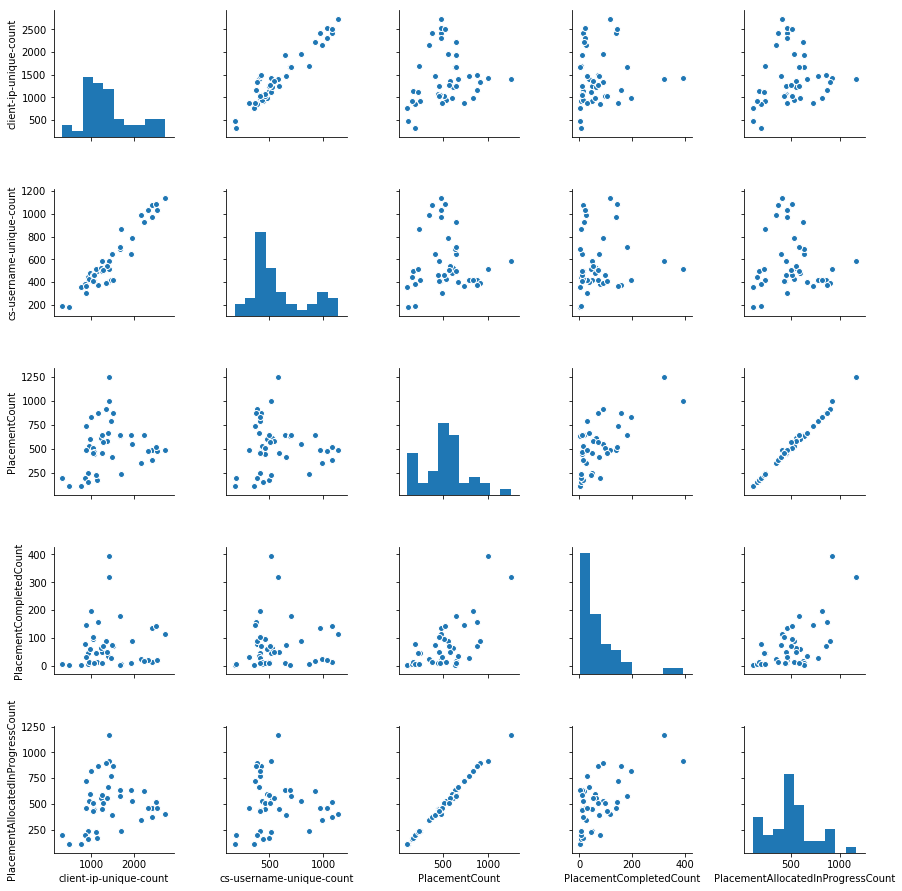

In [13]:
sns.pairplot(data=log_and_placements_aggregated_per_week_df
             ,vars=['client-ip-unique-count','cs-username-unique-count',
                    'PlacementCount', 'PlacementCompletedCount',
                    'PlacementAllocatedInProgressCount'])

In [14]:
log_and_placements_aggregated_per_week_df.reset_index(inplace=True)
log_and_placements_aggregated_per_week_df.head()

,calendar-year-week,client-ip-unique-count,cs-username-unique-count,client-connections-count,time-taken(ms)-sum,Chrome-count,Firefox-count,Other-count,Safari-count,Desktop-count,Mobile-count,PlacementCount,PlacementCompletedCount,PlacementAllocatedInProgressCount,PlacementAllocatedCount,PlacementNotAllocatedCount
0,2017-50,925,415,89497,52520170.0,38500,7784,27741,15472,80440,9057,246,48,234,238,8
1,2017-51,866,386,81378,44703569.0,39664,6585,21274,13855,72925,8453,198,77,196,197,1
2,2017-52,475,179,30843,14199684.0,9978,553,14279,6033,27735,3108,116,3,115,116,0
3,2018-01,769,354,71528,42663674.0,31666,8049,19512,12301,64710,6818,113,4,111,113,0
4,2018-02,920,441,90093,63904084.0,38238,6166,23249,22440,79099,10994,159,7,159,159,0


In [ ]:
df_train = log_and_placements_aggregated_per_week_df.loc[:39,['client-connections-count']]
df_test= log_and_placements_aggregated_per_week_df.loc[40:,['client-connections-count']]

In [ ]:
df_test.tail()

#### Autocorrelation

In [27]:
plot_acf(df_train,lags=30)

NameError: name 'df_train' is not defined

In [ ]:
model = sm.tsa.ARIMA(df_train,(1,0,0)).fit()

predictions = model.predict(40,42,dynamic=True)

predictions

In [ ]:
print("Mean absolute error: ", mean_absolute_error(df_test, predictions))
model.summary()

In [ ]:
df_test

## ARIMA grid search

In [ ]:
import warnings
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
 
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_absolute_error(test, predictions)
    return error
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
 
# load dataset
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(df_train.values, p_values, d_values, q_values)

In [ ]:
df['client-ip'].describe()

## Get an avarage for the period as a baseline to measure success of our model

In [44]:
log_and_placements_aggregated_per_week_df["client-ip-unique-count-MEAN"] =log_and_placements_aggregated_per_week_df["client-ip-unique-count"].mean()


log_and_placements_aggregated_per_week_df["AE"]=np.abs(
    log_and_placements_aggregated_per_week_df["client-ip-unique-count"]- 
    log_and_placements_aggregated_per_week_df["client-ip-unique-count-MEAN"]
)

log_and_placements_aggregated_per_week_df.AE.mean()



459.7836668469445

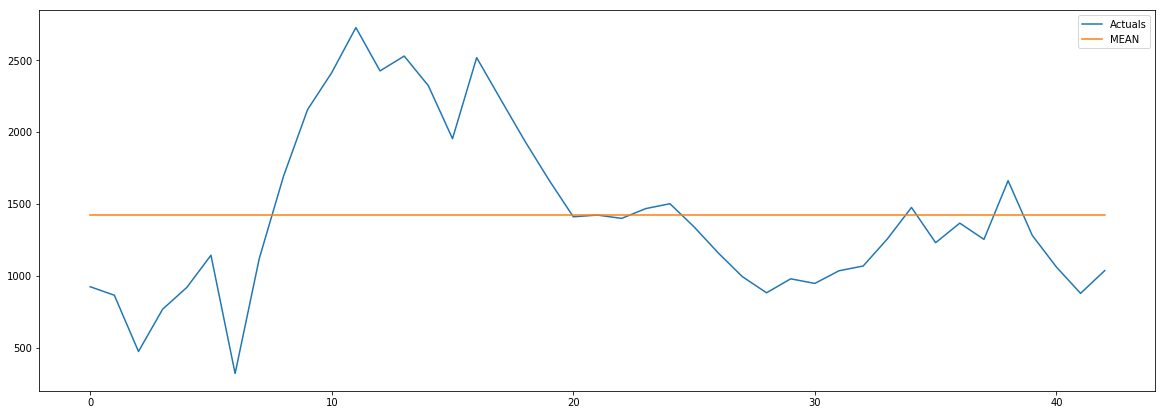

In [39]:
plt.plot(log_and_placements_aggregated_per_week_df.index, log_and_placements_aggregated_per_week_df["client-ip-unique-count"], label='Actuals')
plt.plot(log_and_placements_aggregated_per_week_df.index, log_and_placements_aggregated_per_week_df["client-ip-unique-count-MEAN"], label='MEAN')
plt.legend(loc='best')

## Try same EDA but with data aggregated by day

In [46]:
file_per_day =  "..\data\log_agg_per_day"

In [57]:
df_per_day = pd.DataFrame()
list_ = []

def getListOfFiles(dirName):
        # names in the given directory 
        listOfFile = os.listdir(dirName)
        allFiles = list()

        for file in listOfFile:
            # Create full path
            fullPath = os.path.join(dirName, file)
            # If entry is a directory then get the list of files in this directory 
            if os.path.isdir(fullPath):
                allFiles = allFiles + self.getListOfFiles(fullPath)
            else:
                allFiles.append(fullPath)
        return allFiles
       
listOfFiles = getListOfFiles(file_per_day)

for file in listOfFiles:
    #print(file)
    df = pd.read_csv(file)
    list_.append(df)

df_per_day = pd.concat(list_)

In [4]:
df_per_day = pd.read_csv("../data/log_data_per_day.csv")

In [5]:
df_per_day = df_per_day.sort_values("date").reset_index()

In [6]:
df_per_day.drop(columns="Unnamed: 0",axis=1,inplace=True)

In [7]:
df_per_day.head()

,index,date,client-ip-unique-count,cs-username-unique-count,client-connections-count,time-taken(ms)-sum,Chrome-count,Firefox-count,Other-count,Safari-count,Desktop-count,Mobile-count
0,0,2017-12-11,265,145,22338,12255723.0,9851,2889,6421,3177,20677,1661
1,111,2017-12-12,233,132,19352,9666209.0,8983,1881,5523,2965,17707,1645
2,222,2017-12-13,267,161,19988,14207636.0,9871,1133,4843,4141,17275,2713
3,237,2017-12-14,202,97,12630,9258349.0,4978,809,4440,2403,11034,1596
4,248,2017-12-15,180,82,10433,5169290.0,3805,1059,3583,1986,9413,1020


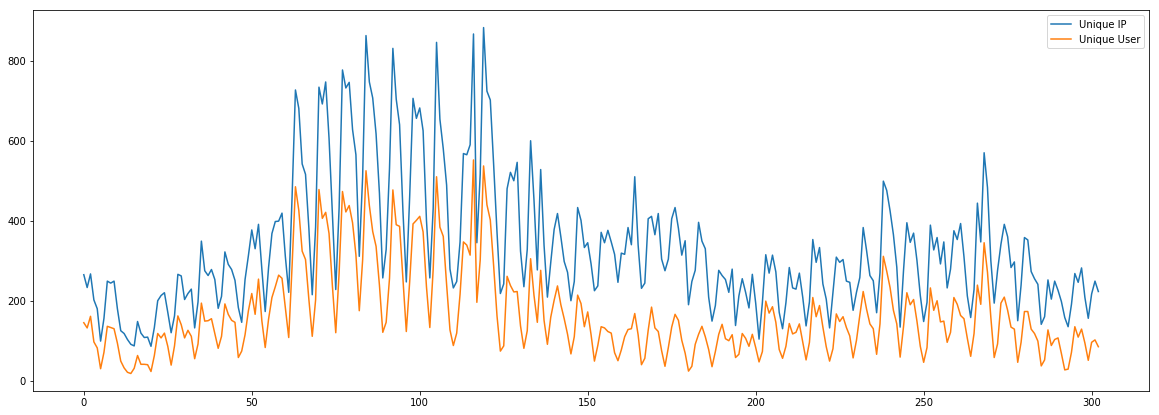

In [10]:
plt.plot(df_per_day.index,df_per_day['client-ip-unique-count'],label="Unique IP")
plt.plot(df_per_day.index,df_per_day['cs-username-unique-count'],label="Unique User")
plt.legend()

In [34]:
df_per_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 11 columns):
date                        303 non-null object
client-ip-unique-count      303 non-null int64
cs-username-unique-count    303 non-null int64
client-connections-count    303 non-null int64
time-taken(ms)-sum          303 non-null float64
Chrome-count                303 non-null int64
Firefox-count               303 non-null int64
Other-count                 303 non-null int64
Safari-count                303 non-null int64
Desktop-count               303 non-null int64
Mobile-count                303 non-null int64
dtypes: float64(1), int64(9), object(1)
memory usage: 26.1+ KB


In [11]:
df_per_day_train = df_per_day.loc[:299,['client-ip-unique-count']]
df_per_day_test= df_per_day.loc[300:,['client-ip-unique-count']]

In [15]:
import warnings
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
 
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_absolute_error(test, predictions)
    return error
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MAE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MAE=%.3f' % (best_cfg, best_score))
 
# load dataset
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(df_per_day_train.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MAE=99.054
ARIMA(0, 0, 1) MAE=72.842
ARIMA(0, 1, 0) MAE=70.475
ARIMA(0, 1, 1) MAE=71.848
ARIMA(0, 1, 2) MAE=58.768
ARIMA(0, 2, 0) MAE=94.575
ARIMA(0, 2, 1) MAE=70.630
ARIMA(0, 2, 2) MAE=72.193
ARIMA(1, 0, 0) MAE=64.118
ARIMA(1, 0, 1) MAE=65.102
ARIMA(1, 0, 2) MAE=58.443
ARIMA(1, 1, 0) MAE=71.053
ARIMA(1, 1, 1) MAE=59.322
ARIMA(1, 1, 2) MAE=59.079
ARIMA(1, 2, 0) MAE=90.789
ARIMA(2, 0, 0) MAE=64.885
ARIMA(2, 0, 1) MAE=65.218
ARIMA(2, 0, 2) MAE=58.816
ARIMA(2, 1, 0) MAE=68.321
ARIMA(2, 1, 1) MAE=56.205
ARIMA(2, 1, 2) MAE=52.499
ARIMA(2, 2, 0) MAE=87.184
ARIMA(2, 2, 2) MAE=56.337
ARIMA(4, 0, 0) MAE=63.295
ARIMA(4, 0, 1) MAE=54.719
ARIMA(4, 0, 2) MAE=48.511
ARIMA(4, 1, 0) MAE=59.395
ARIMA(4, 1, 1) MAE=51.506
ARIMA(4, 1, 2) MAE=44.751
ARIMA(4, 2, 0) MAE=86.615
ARIMA(4, 2, 2) MAE=52.397
ARIMA(6, 0, 0) MAE=49.176
ARIMA(6, 0, 1) MAE=47.462
ARIMA(6, 0, 2) MAE=43.966
ARIMA(6, 1, 0) MAE=45.487
ARIMA(6, 1, 1) MAE=44.785
ARIMA(6, 1, 2) MAE=43.844
ARIMA(6, 2, 0) MAE=53.378
ARIMA(6, 2, 

In [77]:
model = sm.tsa.ARIMA(df_per_day_train,(1,0,4)).fit()

predictions = model.predict(300,302,dynamic=True)

predictions

300    193.650257
301    228.749887
302    229.762578
dtype: float64

In [78]:
df_per_day_test.head()

,client-ip-unique-count
300,217
301,249
302,223


In [79]:
print("Mean absolute error: ", mean_absolute_error(df_per_day_test, predictions))
model.summary()

Mean absolute error:  16.787478000778


<class 'statsmodels.iolib.summary.Summary'>
"""
                                ARMA Model Results                                
==================================================================================
Dep. Variable:     client-ip-unique-count   No. Observations:                  300
Model:                         ARMA(1, 4)   Log Likelihood               -1805.252
Method:                           css-mle   S.D. of innovations             99.078
Date:                    Mon, 19 Nov 2018   AIC                           3624.505
Time:                            13:28:57   BIC                           3650.431
Sample:                                 0   HQIC                          3634.881
                                                                                  
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                          297.0649     70.253      4.229      0.000     159.372     434.757
ar.L1.client-ip-unique-count     0.9852      0.011     93.055      0.000       0.964       1.006
ma.L1.client-ip-unique-count    -0.2135      0.076     -2.796      0.006      -0.363      -0.064
ma.L2.client-ip-unique-count    -0.5253      0.083     -6.308      0.000      -0.689      -0.362
ma.L3.client-ip-unique-count    -0.1204      0.060     -2.006      0.046      -0.238      -0.003
ma.L4.client-ip-unique-count     0.0660      0.105      0.630      0.529      -0.139       0.271
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0150           +0.0000j            1.0150            0.0000
MA.1            1.1447           -0.0000j            1.1447           -0.0000
MA.2           -1.5831           -0.9669j            1.8550           -0.4127
MA.3           -1.5831           +0.9669j            1.8550            0.4127
MA.4            3.8465           -0.0000j            3.8465           -0.0000
-----------------------------------------------------------------------------
"""

In [80]:
df_per_day["client-ip-unique-count-MEAN"] =df_per_day["client-ip-unique-count"].mean()


df_per_day["AE"]=np.abs(
    df_per_day["client-ip-unique-count"]- 
    df_per_day["client-ip-unique-count-MEAN"]
)

df_per_day.AE.mean()



123.66127503839469